# Analysis: Identify Large Prediction Shifts

This is a sandbox notebook for exploring a proof of concept for highlighting large shifts in predictions. The goals are:
- Identify time frames in the game where large shifts in win probability happen
- Use SHAP model analysis to highlight which features caused the shift in predictions

## Setup

In [1]:
%%capture
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import starcraft_predictor as scp
import shap
import matplotlib.pyplot as plt
import seaborn as sns

## Load Replay

In [3]:
# load the example replay
replay = scp.api._load_replay("../example_data/example_replay.SC2Replay")

# process the replay into a dataframe
processed_replay = scp.api._process_replay(replay)

# generate predictions for the replay
predictions = scp.api._generate_predictions(processed_replay)

In [4]:
def get_local_min_max_values(predictions: list) -> list:
    """Iteratively go through a list and
    identify all the local maxima and local minima,
    then return the index of all those points.
    
    eg: given predictions = [1, 3, 5, 3, 2, 8]
    
    The function would return: [0, 2, 4, 5]
    
    """
    
    min_max_points = []
    direction = ""
    for i, pred in enumerate(predictions):
        
        # append the first value as a local maxima/minima
        if i == 0:
            pred_value = pred
            min_max_points.append(0)
        
        # determine the direction at the start
        if i == 1:
            if pred < pred_value:
                direction = "down"
                pred_value = pred
            else:
                direction = "up"
                pred_value = pred
        # iterate through all points, taking note of when
        # direction changes (ie, local maxima/minima)
        else:
            if direction == "down":
                if pred < pred_value:
                    pred_value = pred
                else:
                    min_max_points.append(i-1)
                    direction = "up"
                    pred_value = pred
            elif direction == "up":
                if pred > pred_value:
                    pred_value = pred
                else:
                    min_max_points.append(i-1)
                    direction = "down"
                    pred_value = pred

    min_max_points.append(i)
    
    return min_max_points

In [5]:
def get_differences(predictions, min_max_points):
    """For each pair of local min/max, calculate the
    prediction difference between them.
    
    """
    
    differences = []
    
    for i in range(len(min_max_points) - 1):
        
        differences.append(predictions[min_max_points[i + 1]] - predictions[min_max_points[i]])
    
    return differences

In [6]:
def get_top_three_differences(differences):
    """Get the largest 3 prediction shifts, and the pair it
    with the index of the first point in that shift (note, each
    shift has two points, a max and min).
    
    """
    
    abs_differences = [abs(x) for x in differences]
    
    top_three_shifts = sorted(zip(abs_differences, range(len(differences))), reverse=True)[:3]
    
    return top_three_shifts

In [7]:
def get_value_indexes(min_max_values, difference_index):
    """From the min/max index associated with the large shift, get
    the prediction index.
    
    """
    
    return (min_max_values[difference_index], min_max_values[difference_index + 1])

In [8]:
# note: there are lots of fluctuations at the start, hence many consecutive min/max points
min_max_points = get_local_min_max_values(predictions)
min_max_points[:20]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 22]

In [9]:
# note: the differences should alternative between + and -
differences = get_differences(predictions, min_max_points)
differences[10:20]

[0.016330231387250482,
 -0.008165614083156691,
 0.006803390938168841,
 -0.007484118319714073,
 0.0071436015072812165,
 -0.00731377361474711,
 0.0045429160356502685,
 -0.00889247962831441,
 0.01142015791566342,
 -0.0037130362195095246]

In [10]:
top_three_shifts = get_top_three_differences(differences)
top_three_shifts

[(0.4499071829265089, 32), (0.3998659456010938, 42), (0.253538651907936, 39)]

In [11]:
replay_indexes = [get_value_indexes(min_max_points, x[1]) for x in top_three_shifts]
replay_indexes

[(70, 84), (120, 145), (114, 117)]

The `replay_indexes` shown above represent pairs of points in the game where the prediction probabilities shift the most, where index=0 is the start of the game. To break this down further:

The index pair (70, 84) represents game times 11:30 and 13:50. The model indicates there is a big shift in win probabilty between these two times.

## SHAP Analysis

In [13]:
# Extract XGBoost model and FEATURES list from scp package
pre_trained_model = scp.api.model.model
FEATURES = scp.modelling.model_params.FEATURES

In [14]:
# generate shap values for the processed replay
explainer = shap.TreeExplainer(pre_trained_model)
shap_values = explainer.shap_values(processed_replay[FEATURES])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [15]:
def plot_shap_differences(shap_values, features, index_pair):
    
    # generate plotting dataframe
    plotting_dataframe = pd.DataFrame({
        "features": features,
        "first_index": shap_values[index_pair[0]],
        "second_index": shap_values[index_pair[1]],
        "abs_difference": abs(shap_values[index_pair[0]] - shap_values[index_pair[1]])
    })
    
    plotting_dataframe.sort_values("abs_difference", ascending=False, inplace=True)
    plotting_dataframe.reset_index(inplace=True, drop=True)
    
    # plot the feature contribution for each index
    fig, ax = plt.subplots(figsize=(40,15))

    sns.barplot(
        y=plotting_dataframe["features"],
        x=plotting_dataframe["first_index"],
        color="blue",
        alpha=0.5,
        label="first_index",
    )
    sns.barplot(
        y=plotting_dataframe["features"],
        x=plotting_dataframe["second_index"],
        color="red",
        alpha=0.5,
        label="second_index",
    )
    
    plt.xlabel("prediction contribution")

    plt.legend()
    plt.show()

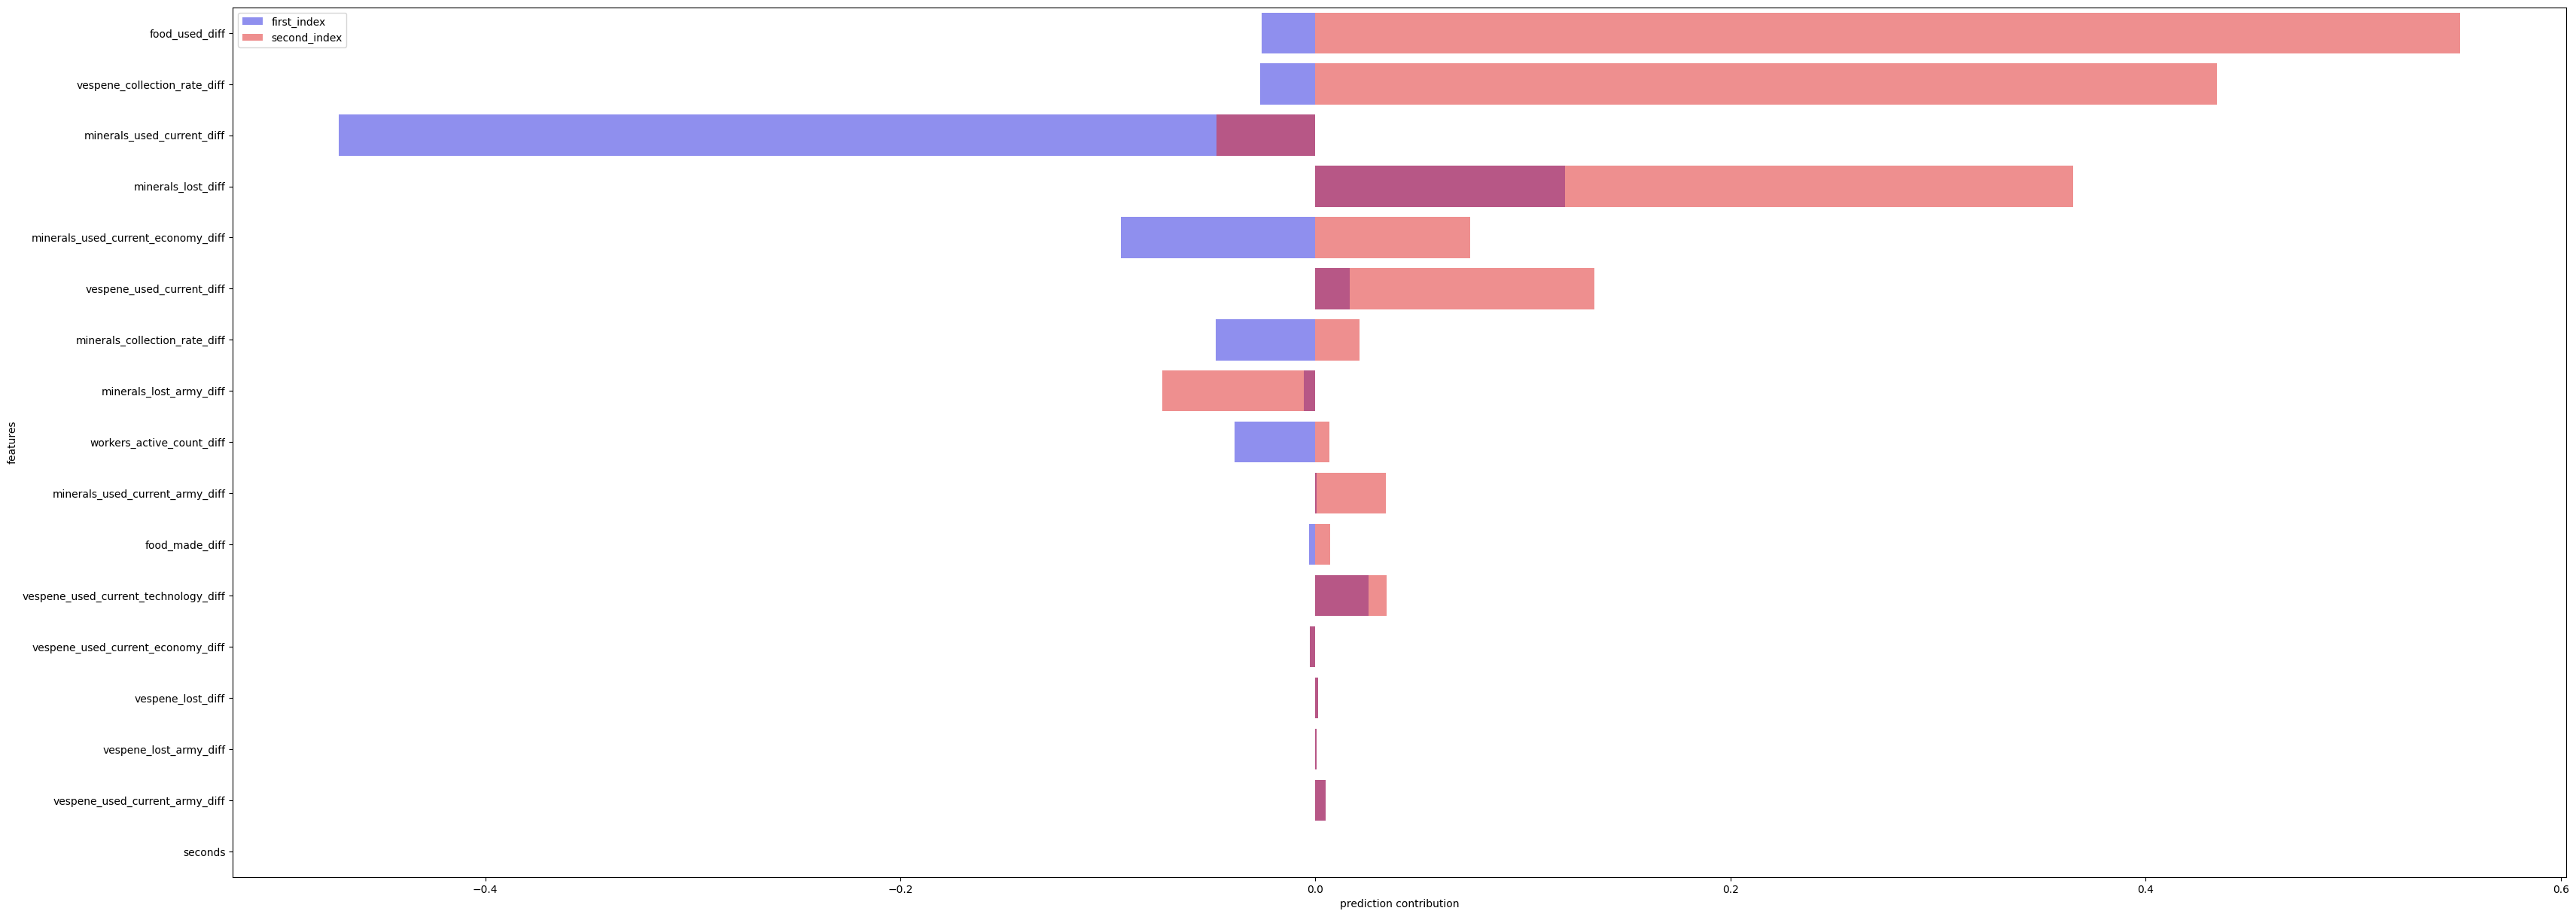

In [16]:
plot_shap_differences(shap_values, FEATURES, (70, 84))

## Plot Explained

The plot shows the feature contribution for the prediction at the first index (blue), and the second index (red). A bar to the left of zero indicates that feature is reducing the prediction, and a bar to the right of zero indicates that feature is increasing the prediction. A big change is indicated by the size gap between the end of the blue bar and the end of the red bar. The features are ordered from top to bottom, starting with the feature that has changed the prediction the most.

Some example insights can we take-away from reading the plot above:
- The feature causing the biggest change in prediction between 11:30 (index 70) and 13:50 (index 84) is `food_used_diff`
- `food_used_diff` reduces the probabiltiy prediction by a small amount for the first index, indicated by a small blue bar to the left.
- `food_used_diff` increased the probabiltiy prediction by a large amount for the second index, indicated by a large red line to the right.
- `minerals_used_current_diff` reduces the probability prediction by a large amount for the first index, indicated by a large blue line to the left.
- `minerals_used_current_diff` reduces the probability prediction by a small amount for the second index, indicated by a small red line to the left.

This gives us direction for what to look at in the data, now we can actually examine these differences!

In [20]:
print(processed_replay.loc[70, "food_used_diff"])
print(processed_replay.loc[84, "food_used_diff"])

-2.0
-33.0


A shift in 31 supply is the main driver for why probability predictions shifted so much.